In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [728]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import pickle
import eli5
from eli5.sklearn import PermutationImportance

In [495]:
plt.style.use('seaborn-poster')

In [747]:
# how to read in data
#data=np.genfromtxt('JohnHopkins_TransitionalTurb/Shaun_JHTDB_data.csv',delimiter=',',names=True)
data2=np.genfromtxt('JohnHopkins_TransitionalTurb/Shaun_JHTDB_data.csv',delimiter=',')

In [746]:
!head -1 'JohnHopkins_TransitionalTurb/Shaun_JHTDB_data.csv'

# p,dudx,dvdx,dpdx,dudy,dvdy,dpdy,d2udx2,d2vdx2,d2pdx2,d2udy2,d2vdy2,d2pdy2,nu,uu,vv,ww,uv,uw,vw


In [748]:
n,dim=data2.shape

In [749]:
dim

20

In [785]:
n

739200

In [750]:
data2.astype(np.float32)

array([[-1.6331943e-02, -6.6910514e-05, -8.7996179e-09, ...,
        -6.1750723e-11, -1.0349927e-10, -2.1503207e-13],
       [-1.6188428e-02, -6.6215718e-05, -8.6795939e-09, ...,
        -6.1714460e-11, -1.0090091e-10, -2.1528883e-13],
       [-1.6047101e-02, -6.5525695e-05, -8.5645055e-09, ...,
        -6.1675789e-11, -9.7685263e-11, -2.1522804e-13],
       ...,
       [ 1.2517463e-03,  1.0810859e-05, -1.6804321e-05, ...,
         5.6871982e-06, -1.2170970e-06, -3.6686271e-07],
       [ 1.2495011e-03,  6.7312894e-06, -1.6914277e-05, ...,
         5.6913459e-06, -1.2195518e-06, -3.6732268e-07],
       [ 1.2472236e-03,  1.1422794e-05, -1.6901131e-05, ...,
         5.6956869e-06, -1.2216458e-06, -3.6737944e-07]], dtype=float32)

In [751]:
allrange = np.arange(n)
np.random.shuffle(allrange)
n70=np.int(0.70*n)
seventy=allrange[:n70]
thirty=allrange[n70:]

In [752]:
n70

517439

In [753]:
print(n,seventy.size + thirty.size)

739200 739200


In [754]:
nin=14
x_train = data2[seventy,:nin]
y_train = data2[seventy,nin:]
x_valid = data2[thirty,:nin]
y_valid = data2[thirty,nin:]

In [755]:
n_train,_ = x_train.shape
x_train_aug = x_train
y_train_aug = y_train
for j in range(1,4):
    randj = np.random.rand(n_train,nin)*0.04 - 0.02 # \in [-0.01,0.01)
    x_train_augj = x_train + randj*x_train # 2% or less of input random
    x_train_aug = np.vstack((x_train_aug,x_train_augj))
    y_train_aug = np.vstack((y_train_aug,y_train))

In [688]:
#x_train_aug_poly3 = PolynomialFeatures(degree=3,include_bias=False,interaction_only=False).fit_transform(x_train_aug)
#x_valid_poly3 = PolynomialFeatures(degree=3,include_bias=False,interaction_only=False).fit_transform(x_valid)
x_train_aug_poly2 = PolynomialFeatures(degree=2,include_bias=False,interaction_only=False).fit_transform(x_train_aug)
x_valid_poly2 = PolynomialFeatures(degree=2,include_bias=False,interaction_only=False).fit_transform(x_valid)

In [590]:
print(x_train_aug_poly3.shape)
print(x_train_aug.shape)

(2069756, 679)
(2069756, 14)


In [774]:
# scikit-learn svr
#svr = GridSearchCV(SVR(kernel='rbf', gamma=0.2),
                   #param_grid={"C": [1e-2,1e-1,1e0, 1e1, 1e2],
                               #"gamma": np.logspace(-4, 4, 8)})
#svr = SVR(kernel='rbf',C=10**200,gamma='auto')
#svr = LinearRegression(fit_intercept=False)
#def zero_negative(x):
    #x[x<0]=0
    #return x
linear = Pipeline([
    ('poly',PolynomialFeatures(degree=3,include_bias=False,interaction_only=False)),
    #('negative',FunctionTransformer(zero_negative)),
    ('linear',LinearRegression(fit_intercept=False)),
])
#svr = Ridge(fit_intercept=False,tol=1E-9)
%time linear.fit(x_train_aug,y_train_aug[:,0])

CPU times: user 11min 39s, sys: 4min 49s, total: 16min 29s
Wall time: 2min 8s


Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=3, include_bias=False,
                                    interaction_only=False, order='C')),
                ('linear',
                 LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
                                  normalize=False))],
         verbose=False)

/home/srharris/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


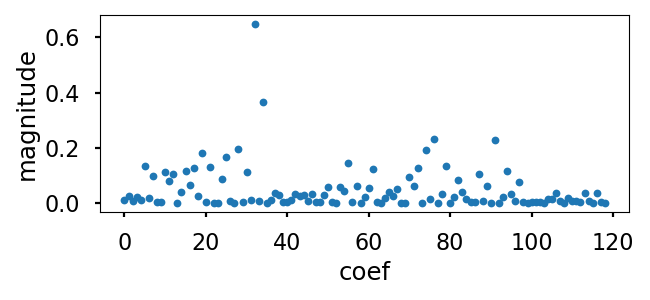

104

In [724]:
fig,ax=plt.subplots(figsize=(6.5,3))
ax.plot(np.abs(linear['linear'].coef_*np.max(np.abs(x_train_aug_poly2),axis=0)),'.')
ax.set_xlabel(r'coef')
ax.set_ylabel('magnitude')
fig.tight_layout()
np.argmax(linear['linear'].coef_)

In [780]:
perm=PermutationImportance(linear,random_state=1).fit(x_train_aug,y_train_aug[:,0])
eli5.show_weights(perm)

Weight,Feature
1294.4261 ± 25.3066,x5
324.8356 ± 12.2379,x1
109.1876 ± 2.1353,x4
94.0471 ± 3.4430,x10
72.4699 ± 4.9553,x2
47.3593 ± 0.6829,x12
21.5922 ± 0.1050,x3
14.0522 ± 0.3132,x6
8.5608 ± 0.1338,x0
2.1770 ± 0.0234,x11


In [781]:
perm_poly3_again = perm
eli5.show_weights(perm_poly3_again)

Weight,Feature
1294.4261 ± 25.3066,x5
324.8356 ± 12.2379,x1
109.1876 ± 2.1353,x4
94.0471 ± 3.4430,x10
72.4699 ± 4.9553,x2
47.3593 ± 0.6829,x12
21.5922 ± 0.1050,x3
14.0522 ± 0.3132,x6
8.5608 ± 0.1338,x0
2.1770 ± 0.0234,x11


In [744]:
#perm_poly3 = perm
eli5.show_weights(perm_poly3)

Weight,Feature
3759.7958 ± 38.7736,x5
2856.4634 ± 17.8306,x7
109.0663 ± 0.4111,x4
97.2207 ± 2.2722,x1
84.0239 ± 2.0190,x10
44.0546 ± 2.4233,x2
38.7414 ± 0.2613,x12
24.6513 ± 0.2335,x3
13.5472 ± 0.2428,x6
8.5776 ± 0.2029,x0


In [745]:
#perm_poly2 = perm
eli5.show_weights(perm_poly2)

Weight,Feature
24.5285 ± 0.0784,x10
15.9924 ± 0.0315,x12
4.0582 ± 0.0200,x7
3.4826 ± 0.0162,x4
2.4355 ± 0.0085,x6
2.2674 ± 0.0217,x0
2.2031 ± 0.0087,x3
1.6168 ± 0.0099,x1
1.2275 ± 0.0072,x5
0.9229 ± 0.0045,x11


In [768]:
#perm_poly2_again = perm
eli5.show_weights(perm_poly2_again)

Weight,Feature
26.1910 ± 0.0098,x10
15.0344 ± 0.0669,x12
4.7703 ± 0.0285,x1
3.5213 ± 0.0129,x4
2.5225 ± 0.0083,x6
2.4404 ± 0.0194,x0
2.2808 ± 0.0043,x3
1.8278 ± 0.0133,x5
1.3177 ± 0.0066,x11
0.2454 ± 0.0064,x2


In [730]:
x_train_aug.shape

(2069756, 14)

In [721]:
x_train_aug_poly2.shape

(2069756, 119)

In [727]:
linear['poly'].get_feature_names()[34]

'x1 x7'

In [775]:
#print(svr.score(x_train_aug,y_train_aug[:,0]))
#print(linear.score(x_valid,y_valid[:,0]))
display(Latex(r'LR training $R^2$ = {:g}'.format(linear.score(x_train_aug,y_train_aug[:,0]))))
display(Latex(r'LR test $R^2$ = {:g}'.format(linear.score(x_valid,y_valid[:,0]))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [776]:
pickle.dump(linear,open('upup_poly3_linear_4aug.dat.p','wb'))

In [508]:
model = pickle.load(open('upup_poly3_linear_1aug.dat.p','rb'))

In [653]:
class linearRegression(torch.nn.Module):
    def __init__(self,inputSize,outputSize):
        super(linearRegression,self).__init__()
        self.linear = torch.nn.Linear(inputSize,outputSize)
        
    def forward(self,x):
        out = self.linear(x)
        return out
    
class NN1(torch.nn.Module):
    def __init__(self,inputSize,outputSize):
        super(NN1,self).__init__()
        self.linear1 = torch.nn.Linear(inputSize,64)
        #self.activ1  = torch.nn.PReLU()
        self.activ1  = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(64,outputSize)
        #self.activ2  = torch.nn.PReLU()
        #self.linear3 = torch.nn.Linear(64,64)
        #self.activ3  = torch.nn.Sigmoid()
        #self.linear4 = torch.nn.Linear(64,64)
        #self.activ4  = torch.nn.PReLU()
        #self.linear5 = torch.nn.Linear(64,outputSize)
        
    def forward(self,x):
        out = self.linear1(x)
        out = self.activ1(out)
        out = self.linear2(out)
        #out = self.activ2(out)
        #out = self.linear3(out)
        #out = self.activ3(out)
        #out = self.linear4(out)
        #out = self.activ4(out)
        #out = self.linear5(out)
        return out
class NN2(torch.nn.Module):
    def __init__(self,inputSize,outputSize):
        super(NN2,self).__init__()
        self.linear1 = torch.nn.Linear(inputSize,300)
        #self.activ1  = torch.nn.PReLU()
        self.activ1  = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(300,300)
        self.activ2  = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(300,300)
        self.activ3  = torch.nn.ReLU()
        self.linear4 = torch.nn.Linear(300,300)
        self.activ4  = torch.nn.ReLU()
        self.linear5 = torch.nn.Linear(300,outputSize)
        self.activ5  = torch.nn.ReLU()
        #self.linear3 = torch.nn.Linear(64,64)
        #self.activ3  = torch.nn.Sigmoid()
        #self.linear4 = torch.nn.Linear(64,64)
        #self.activ4  = torch.nn.PReLU()
        #self.linear5 = torch.nn.Linear(64,outputSize)
        
    def forward(self,x):
        out = self.linear1(x)
        out = self.activ1(out)
        out = self.linear2(out)
        out = self.activ2(out)
        out = self.linear3(out)
        out = self.activ3(out)
        out = self.linear4(out)
        out = self.activ4(out)
        out = self.linear5(out)
        out = self.activ5(out)
        return out
class NN3(torch.nn.Module):
    def __init__(self,inputSize,outputSize):
        super(NN3,self).__init__()
        self.linear1 = torch.nn.Linear(inputSize,100)
        self.activ1  = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(100,outputSize)
        
    def forward(self,x):
        out = self.linear1(x)
        out = self.activ1(out)
        out = self.linear2(out)
        return out

class Autoencoder(torch.nn.Module): # if solving for entire domain at once...
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(16,6,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,3,kernel_size=5),
            nn.ReLU(True),
            nn.Sigmoid())
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [670]:
#model = linearRegression(nin,1) # linear model with 1 inputSize and 1 outputSize
#model = NN3(nin,1) # linear model with 1 inputSize and 1 outputSize
#_,nin = x_train_aug_poly3.shape
_,nin = x_train_aug.shape
model = NN3(nin,1) # linear model with 1 inputSize and 1 outputSize
#model = linearRegression(nin,1) # linear model with 1 inputSize and 1 outputSize
#model = linearRegression(nin-2,1) # linear model with 1 inputSize and 1 outputSize

In [671]:
#criterion = torch.nn.L1Loss() # Mean Squared Error loss function
#criterion = torch.nn.MSELoss(reduction='sum') # Mean Squared Error loss function
criterion = torch.nn.MSELoss() # Mean Squared Error loss function

In [677]:
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.005,momentum=0.01)#,dampening=0.01) # stochastic gradient descent with 0.01 learning rate
optimizer = torch.optim.Adam(model.parameters(),lr=0.02) # stochastic gradient descent with 0.01 learning rate

In [678]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [679]:
#inputs = torch.autograd.Variable(torch.from_numpy(x_train_aug_poly3.astype(np.float32)))
inputs = torch.autograd.Variable(torch.from_numpy(x_train_aug.astype(np.float32)))
labels = torch.autograd.Variable(torch.from_numpy(y_train_aug[:,0].reshape(-1,1).astype(np.float32)))
for epoch in range(3000):
    #inputs = torch.autograd.Variable(torch.from_numpy(x_train.astype(np.float32)))
    #labels = torch.autograd.Variable(torch.from_numpy(y_train[:,1].reshape(-1,1).astype(np.float32)))
    #labels = torch.autograd.Variable(torch.from_numpy(y_train.astype(np.float32)))
    # on augmented data
    #inputs = torch.autograd.Variable(torch.from_numpy(x_train_aug_poly3.astype(np.float32)))
    #labels = torch.autograd.Variable(torch.from_numpy(y_train_aug[:,0].reshape(-1,1).astype(np.float32)))
    
    # clear gradient buffers
    optimizer.zero_grad()
    
    # get output from model
    outputs = model(inputs)
    
    # get loss
    loss = criterion(outputs,labels)
    # get gradients w.r.t. to parameters
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    print('epoch {}, loss {}'.format(epoch, loss.item()))
    if loss.item()<=1E-10:
        break

epoch 0, loss 9.840494385571219e-06
epoch 1, loss 0.0002251128462376073
epoch 2, loss 0.0019866793882101774
epoch 3, loss 8.932811033446342e-05
epoch 4, loss 0.00047581674880348146
epoch 5, loss 0.0008646223577670753
epoch 6, loss 0.0005248414818197489
epoch 7, loss 0.00011757266474887729
epoch 8, loss 2.5875613573589362e-05
epoch 9, loss 0.0001892440050141886
epoch 10, loss 0.00032377225579693913
epoch 11, loss 0.0002798160712700337
epoch 12, loss 0.00013818468141835183
epoch 13, loss 3.0461475034826435e-05
epoch 14, loss 1.2480642908485606e-05
epoch 15, loss 5.91121606703382e-05
epoch 16, loss 0.00011367647675797343
epoch 17, loss 0.00013414847489912063
epoch 18, loss 0.00011172007361892611
epoch 19, loss 6.567959644598886e-05
epoch 20, loss 2.526229218346998e-05
epoch 21, loss 1.1179079592693597e-05
epoch 22, loss 2.5012386686285026e-05
epoch 23, loss 5.0781702157109976e-05
epoch 24, loss 6.791583291487768e-05
epoch 25, loss 6.511199899250641e-05
epoch 26, loss 4.615173384081572e-05

epoch 218, loss 4.226276359986514e-06
epoch 219, loss 4.21766117142397e-06
epoch 220, loss 4.2092233343282714e-06
epoch 221, loss 4.20100968767656e-06
epoch 222, loss 4.1928051359718665e-06
epoch 223, loss 4.1845382838801015e-06
epoch 224, loss 4.176350557827391e-06
epoch 225, loss 4.1683206291054375e-06
epoch 226, loss 4.160343451076187e-06
epoch 227, loss 4.152327164774761e-06
epoch 228, loss 4.144341801293194e-06
epoch 229, loss 4.1364824028278235e-06
epoch 230, loss 4.128721684537595e-06
epoch 231, loss 4.120947778574191e-06
epoch 232, loss 4.113145678275032e-06
epoch 233, loss 4.105407242604997e-06
epoch 234, loss 4.097768851352157e-06
epoch 235, loss 4.090168658876792e-06
epoch 236, loss 4.082559371454408e-06
epoch 237, loss 4.074966000189306e-06
epoch 238, loss 4.0674231058801524e-06
epoch 239, loss 4.0599129533802625e-06
epoch 240, loss 4.052408257848583e-06
epoch 241, loss 4.044920387968887e-06
epoch 242, loss 4.037472081108717e-06
epoch 243, loss 4.030046511616092e-06
epoch 2

epoch 432, loss 2.950467433038284e-06
epoch 433, loss 2.9448683562804945e-06
epoch 434, loss 2.939282239822205e-06
epoch 435, loss 2.933707037300337e-06
epoch 436, loss 2.928142521341215e-06
epoch 437, loss 2.9225907383079175e-06
epoch 438, loss 2.9170514608267695e-06
epoch 439, loss 2.9115255983924726e-06
epoch 440, loss 2.906013151005027e-06
epoch 441, loss 2.900515482906485e-06
epoch 442, loss 2.895032139349496e-06
epoch 443, loss 2.889562210839358e-06
epoch 444, loss 2.884105924749747e-06
epoch 445, loss 2.8786664643121185e-06
epoch 446, loss 2.8732431474054465e-06
epoch 447, loss 2.8678346097876783e-06
epoch 448, loss 2.862442443074542e-06
epoch 449, loss 2.8570664198923623e-06
epoch 450, loss 2.851709041351569e-06
epoch 451, loss 2.8463716716942145e-06
epoch 452, loss 2.841051809809869e-06
epoch 453, loss 2.83575059256691e-06
epoch 454, loss 2.830468247339013e-06
epoch 455, loss 2.825207047862932e-06
epoch 456, loss 2.819966766764992e-06
epoch 457, loss 2.8147469492978416e-06
epo

KeyboardInterrupt: 

## Notes:

For $\overline{u'u'}$ the MSE ends up well around the 1E-7 value range.  Adam with lr=2

For $\overline{v'v'}$ the with adam training 0.02 MSE ends up well in the range .

In [603]:
# save model
torch.save(model,'upup_nn_poly3_4aug.pt')

/home/srharris/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type NN3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [64]:
# load model
model_to_load = 'vpvp_model.pt'
model2 = torch.load('vpvp_model.pt')
model2.eval()

NN1(
  (linear1): Linear(in_features=16, out_features=64, bias=True)
  (activ1): ReLU()
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)

In [18]:
# import case and try it
import h5py

In [19]:
from IPython.display import display, Latex
%matplotlib notebook
plt.style.use('seaborn-paper')

In [20]:
Base=h5py.File('JohnHopkins_TransitionalTurb/Transition_BL_Time_Averaged_Profiles.h5')

In [21]:
u=Base['um'][:]
uu=Base['uum'][:]
v=Base['vm'][:]
vv=Base['vvm'][:]
w=Base['wm'][:]
ww=Base['wwm'][:]
p=Base['pm'][:]
pp=Base['ppm'][:]
uv=Base['uvm'][:]
uw=Base['uwm'][:]
vw=Base['vwm'][:]
x=Base['x_coor'][:]
y=Base['y_coor'][:]
z=Base['z_coor'][:]

In [22]:
X,Y=np.meshgrid(x,y)

<IPython.core.display.Javascript object>


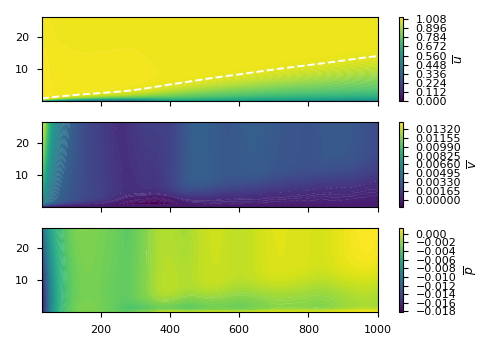

In [23]:
fig,axs=plt.subplots(figsize=(5,3.5),nrows=3,sharey=True,sharex=True)
#axU,axV,axW,axP=axs
axU,axV,axP=axs
#cnt = axU.pcolormesh(x,y,u,cmap=plt.cm.jet)
cnt = axU.contourf(x,y,u,128,cmap=plt.cm.viridis)
fig.colorbar(cnt,ax=axU,label=r'$\overline{u}$')
for c in cnt.collections:
    c.set_edgecolor("face")
axU.contour(x,y,u,levels=[0.99,],colors='w',linestyles='--')
#cnt = axV.pcolormesh(x,y,v)
cnt = axV.contourf(x,y,v,128,cmap=plt.cm.viridis)
fig.colorbar(cnt,ax=axV,label=r'$\overline{v}$')
for c in cnt.collections:
    c.set_edgecolor("face")
#fig.colorbar(axW.pcolormesh(x,y,w),ax=axW,label=r'$\overline{w}$')
#cnt = axP.pcolormesh(x,y,p)
cnt = axP.contourf(x,y,p,128,cmap=plt.cm.viridis)
fig.colorbar(cnt,ax=axP,label=r'$\overline{p}$')
for c in cnt.collections:
    c.set_edgecolor("face")

#[ax.set_aspect('equal') for ax in axs]
fig.tight_layout()
#fig.savefig('uvP_baseflow.eps',format='eps',dpi=600)
fig.savefig('uvP_baseflow.png',dpi=600)

<IPython.core.display.Javascript object>


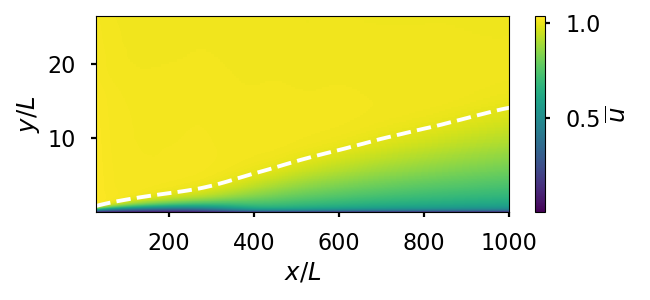

<IPython.core.display.Javascript object>


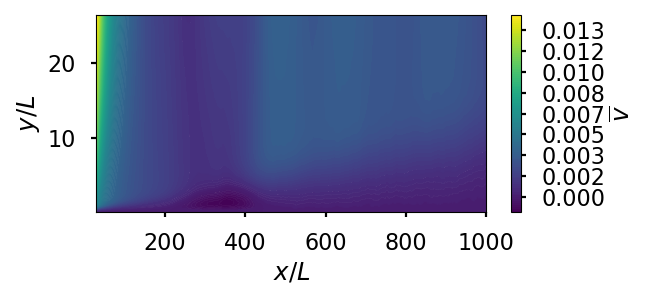

<IPython.core.display.Javascript object>


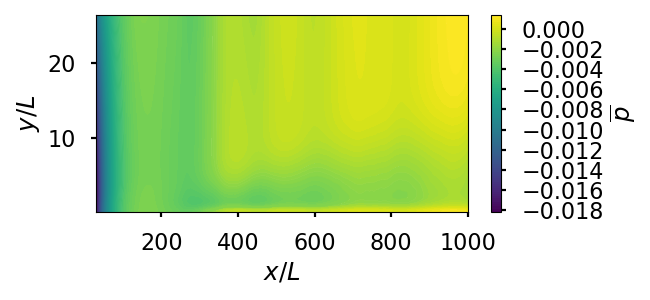

In [784]:
#figU,axU=plt.subplots(figsize=(2.9,2))
#figV,axV=plt.subplots(figsize=(2.9,2))
#figP,axP=plt.subplots(figsize=(2.9,2))
figU,axU=plt.subplots(figsize=(6.5,3))
figV,axV=plt.subplots(figsize=(6.5,3))
figP,axP=plt.subplots(figsize=(6.5,3))
#axU,axV,axW,axP=axs
#cnt = axU.pcolormesh(x,y,u,cmap=plt.cm.jet)
cnt = axU.pcolormesh(x,y,u,cmap=plt.cm.viridis)
figU.colorbar(cnt,ax=axU,format='%.1f',label=r'$\overline{u}$')
#for c in cnt.collections:
    #c.set_edgecolor("face")
axU.contour(x,y,u,levels=[0.99,],colors='w',linestyles='--')
axU.set_xlabel(r'$x/L$')
axU.set_ylabel(r'$y/L$')
#cnt = axV.pcolormesh(x,y,v)
cnt = axV.contourf(x,y,v,128,cmap=plt.cm.viridis)
figV.colorbar(cnt,ax=axV,format='%.3f',label=r'$\overline{v}$')
for c in cnt.collections:
    c.set_edgecolor("face")
axV.set_xlabel(r'$x/L$')
axV.set_ylabel(r'$y/L$')
#fig.colorbar(axW.pcolormesh(x,y,w),ax=axW,label=r'$\overline{w}$')
#cnt = axP.pcolormesh(x,y,p)
cnt = axP.contourf(x,y,p,128,cmap=plt.cm.viridis)
figP.colorbar(cnt,ax=axP,label=r'$\overline{p}$')
for c in cnt.collections:
    c.set_edgecolor("face")
axP.set_xlabel(r'$x/L$')
axP.set_ylabel(r'$y/L$')

#[ax.set_aspect('equal') for ax in axs]
figU.tight_layout()
figV.tight_layout()
figP.tight_layout()
#fig.savefig('uvP_baseflow.eps',format='eps',dpi=600)
figU.savefig('u_baseflow_poster.png',dpi=600)
figV.savefig('v_baseflow_poster.png',dpi=600)
figP.savefig('P_baseflow_poster.png',dpi=600)

<IPython.core.display.Javascript object>


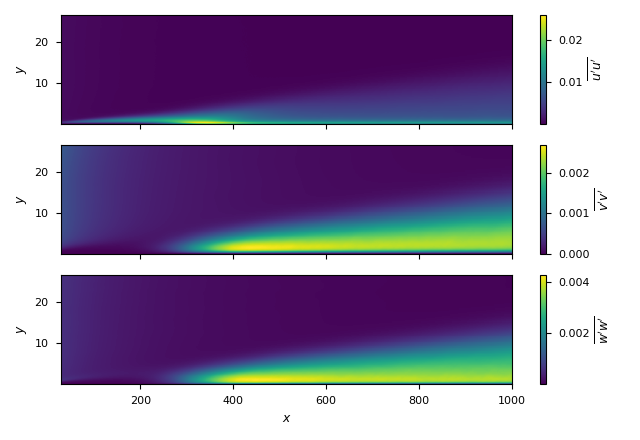

In [25]:
fig,axs=plt.subplots(nrows=3,sharey=True,sharex=True)
axU,axV,axW=axs
fig.colorbar(axU.pcolormesh(x,y,uu-u*u),ax=axU,label=r"$\overline{u'u'}$")
fig.colorbar(axV.pcolormesh(x,y,vv-v*v),ax=axV,label=r"$\overline{v'v'}$")
fig.colorbar(axW.pcolormesh(x,y,ww-w*w),ax=axW,label=r"$\overline{w'w'}$")
axW.set_xlabel(r'$x$')
[ax.set_ylabel(r'$y$') for ax in axs]
fig.tight_layout()

In [26]:
from scipy.special import factorial

In [27]:
def get_D_Coeffs(s,d=2):
    '''
    Solve arbitrary stencil points s of length N with order of derivatives d<N
    can be obtained from equation on MIT website
    http://web.media.mit.edu/~crtaylor/calculator.html
    where the accuracy is determined as the usual form O(h^(N-d))
    
    Inputs:
        s: array like input of stencil points e.g. np.array([-3,-2,-1,0,1])
        d: order of desired derivative
    '''
    # let's solve an Ax=b problem
    N=s.size # stencil length
    A=[]
    for i in range(N):
        A.append(s**i)
    b=np.zeros(N)
    b[d] = factorial(d)
    x = np.linalg.solve(np.matrix(A),b)
    return x
def set_D(y,order=2,d=2,reduce_wall_order=True,output_full=False,periodic=False,uniform=True):
    '''
    Input:
        y: array of y values of channel
        order: order of accuracy desired (assuming even e.g. 2,4,6,...)
        d: dth derivative
    Output:
        D: (n-2 by n) dth derivative of order O(h^order) assuming uniform y spacing
    '''
    h = y[1]-y[0] # uniform spacing
    if not uniform:
        xi=np.linspace(0,1,y.size)
        h=xi[1] - xi[0]
    n = y.size
    ones=np.ones(n)
    I = np.eye(n)
    # get coefficients for main diagonals
    N=order+d # how many pts needed for order of accuracy
    if N>n:
        raise ValueError('You need more points in your domain, you need %i pts and you only gave %i'%(N,n))
    Nm1=N-1 # how many pts needed if using central difference is equal to N-1
    if (d % 2 != 0): # if odd derivative
        Nm1+=1 # add one more point to central, to count the i=0 0 coefficient
    # stencil and get Coeffs for diagonals
    s = np.arange(Nm1)-int((Nm1-1)/2) # stencil for central diff of order
    smax=s[-1] # right most stencil used (positive range)
    Coeffs = get_D_Coeffs(s,d=d)
    # loop over s and add coefficient matrices to D
    D = np.zeros_like(I)
    si = np.nditer(s,('c_index',))
    while not si.finished:
        i = si.index
        if si[0]==0:
            diag_to_add = np.diag(Coeffs[i] * ones,k=si[0])
        else:
            diag_to_add = np.diag(Coeffs[i] * ones[:-abs(si[0])],k=si[0])

        D += diag_to_add
        if periodic:
            if si[0]>0:
                diag_to_add = np.diag(Coeffs[i]*ones[:abs(si[0])],k=si[0]-n)
            elif si[0]<0:
                diag_to_add = np.diag(Coeffs[i]*ones[:abs(si[0])],k=si[0]+n)
            if si[0]!=0:
                D += diag_to_add
                
        si.iternext()
    if not periodic:
        # alter BC so we don't go out of range on bottom of channel
        for i in range(0,smax):
            # for ith row, set proper stencil coefficients
            if reduce_wall_order:
                if (d%2!=0): # if odd derivative
                    s = np.arange(Nm1-1)-i # stencil for shifted diff of order-1
                else:
                    s = np.arange(Nm1)-i # stencil for shifted diff of order-1
            else:
                s = np.arange(N)-i # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D[i,:] = 0. # set row to zero
            D[i,s+i] = Coeffs # set row to have proper coefficients

            # for -ith-1 row, set proper stencil coefficients
            if reduce_wall_order:
                if (d%2!=0): # if odd derivative
                    s = -(np.arange(Nm1-1)-i) # stencil for shifted diff of order-1
                else:
                    s = -(np.arange(Nm1)-i) # stencil for shifted diff of order-1
            else:
                s = -(np.arange(N)-i) # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D[-i-1,:] = 0. # set row to zero
            D[-i-1,s-i-1] = Coeffs # set row to have proper coefficients

    if output_full:
        D = (1./(h**d)) * D # do return the full matrix
    else:
        D = (1./(h**d)) * D[1:-1,:] # do not return the top or bottom row
    if not uniform:
        D = map_D(D,y,order=order,d=d,reduce_wall_order=reduce_wall_order,output_full=output_full,periodic=periodic,uniform=uniform)
    return D 
def map_D(D,y,order=2,d=2,reduce_wall_order=True,output_full=False,periodic=False,uniform=True):
    if not uniform:
        xi=np.linspace(0,1,y.size)
        if d==1: # if 1st derivative operator d(.)/dy = d(.)/dxi * dxi/dy
            dydxi = D@y # matrix multiply in python3
            dxidy = 1./dydxi # element wise invert
            return D*dxidy[:,np.newaxis] # d(.)/dy = d(.)/dxi * dxi/dy
        elif d==2: # d^2()/dy^2 = d^2()/dxi^2 (dxi/dy)^2 + d()/dxi d^2xi/dy^2
            D1=set_D(xi,order=order,d=1,reduce_wall_order=reduce_wall_order,output_full=output_full,periodic=periodic,uniform=True)
            dydxi = D1@y
            dxidy = 1./dydxi # element wise invert
            #d2ydxi2 = D@y # d^2y/dxi^2
            #d2xidy2 = 1./d2ydxi2 # d^2xi/dy^2 = 1./(d^2y/dxi^2)
            d2xidy2 = -(D@y)*(dxidy)**3
            #print('d2xidy2 = ',d2xidy2)
            return (D*(dxidy[:,np.newaxis]**2)) + (D1*d2xidy2[:,np.newaxis])  # d^2()/dy^2 = d^2()/dxi^2 (dxi/dy)^2 + d()/dxi d^2xi/dy^2
        else:
            print('Cannot do this order of derivative with non-uniform mesh.  your input order of derivative = ',d)
    else:
        return D

In [28]:
# derivative operators on data set
Dx = set_D(x,d=1,output_full=True,uniform=False)
Dy = set_D(y,d=1,output_full=True,uniform=False)
Dxx = set_D(x,d=2,output_full=True,uniform=False)
Dyy = set_D(y,d=2,output_full=True,uniform=False)
def ddx(var):
    '''Take derivative with respect to x
    Inputs:
      var - variable to take derivative of
    Returns:
      d(var)/dx
      
    Be sure that x and Dx are global variables defined already and that var is of shape (nx,ny)
    
    '''
    dvar_dx = Dx@var
    return dvar_dx
def ddy(var):
    '''Take derivative with respect to y
    Inputs:
      var - variable to take derivative of
    Returns:
      d(var)/dy
      
    Be sure that y and Dy are global variables defined already and that var is of shape (nx,ny)
    
    '''
    dvar_dy = Dy@(var.T)
    return dvar_dy.T
def d2dx2(var):
    '''Take second derivative with respect to x
    Inputs:
      var - variable to take derivative of
    Returns:
      d^2(var)/dx^2
      
    Be sure that x and Dxx are global variables defined already and that var is of shape (nx,ny)
    
    '''
    d2var_dx2 = Dxx@var
    return d2var_dx2
def d2dy2(var):
    '''Take second derivative with respect to y
    Inputs:
      var - variable to take derivative of
    Returns:
      d^2(var)/dy^2
      
    Be sure that y and Dyy are global variables defined already and that var is of shape (nx,ny)
    
    '''
    d2var_dy2 = Dyy@(var.T)
    return d2var_dy2.T

In [29]:
nu=1./800.

In [410]:
p.size

743680

In [757]:
data = np.zeros((p[:,10:-10].size,nin))
#data[:,0]=u.flatten()
#data[:,1]=v.flatten()
data[:,0]=p[:,10:-10].flatten()
data[:,1]=ddx(u.T).T[:,10:-10].flatten()
data[:,2]=ddx(v.T).T[:,10:-10].flatten()
data[:,3]=ddx(p.T).T[:,10:-10].flatten()
data[:,4]=ddy(u.T).T[:,10:-10].flatten()
data[:,5]=ddy(v.T).T[:,10:-10].flatten()
data[:,6]=ddy(p.T).T[:,10:-10].flatten()
data[:,7]=d2dx2(u.T).T[:,10:-10].flatten()
data[:,8]=d2dx2(v.T).T[:,10:-10].flatten()
data[:,9]=d2dx2(p.T).T[:,10:-10].flatten()
data[:,10]=d2dy2(u.T).T[:,10:-10].flatten()
data[:,11]=d2dy2(v.T).T[:,10:-10].flatten()
data[:,12]=d2dy2(p.T).T[:,10:-10].flatten()
data[:,13]=nu


In [31]:
X.flatten()

array([  30.21849617,   30.51070664,   30.80291711, ...,  999.48061269,
        999.77282316, 1000.06503362])

In [777]:
linear_predict=linear.predict(data[:,:nin])

In [509]:
linear_predict=model.predict(data[:,:nin])

In [599]:
with torch.no_grad():
    data_aug = PolynomialFeatures(degree=3,include_bias=False,interaction_only=False).fit_transform(data[:,:nin])
    predicted = model(torch.autograd.Variable(torch.from_numpy(data_aug.astype(np.float32)))).data.numpy()
    #predicted = model(torch.autograd.Variable(torch.from_numpy(data[:,:nin].astype(np.float32)))).data.numpy()
    #print(predicted)
    #print((uu-u*u).flatten())
    #print((vv-v*v).flatten())


In [601]:
with torch.no_grad():
    train_aug = PolynomialFeatures(degree=3,include_bias=False,interaction_only=False).fit_transform(x_train_aug)
    valid_aug = PolynomialFeatures(degree=3,include_bias=False,interaction_only=False).fit_transform(x_valid)
    inputs_train = torch.autograd.Variable(torch.from_numpy(train_aug.astype(np.float32)))
    inputs_valid = torch.autograd.Variable(torch.from_numpy(valid_aug.astype(np.float32)))
    predicted_train = model(inputs_train)
    predicted_test = model(inputs_valid)

display(Latex(r'LR training $R^2$ = {:g}'.format(r2_score(predicted_train,y_train_aug[:,0]))))
display(Latex(r'LR test $R^2$ = {:g}'.format(r2_score(predicted_test,y_valid[:,0]))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [152]:
print(uu.shape)
print(svr_predict.shape)

(224, 3320)
(743680,)


<IPython.core.display.Javascript object>


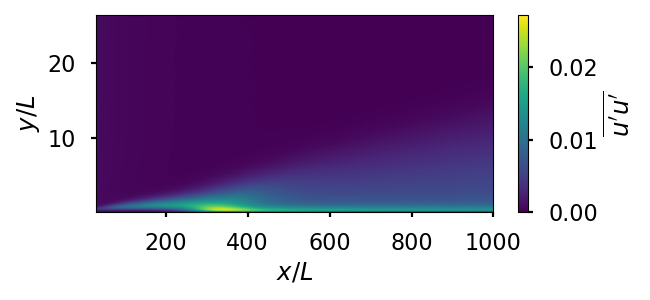

<IPython.core.display.Javascript object>


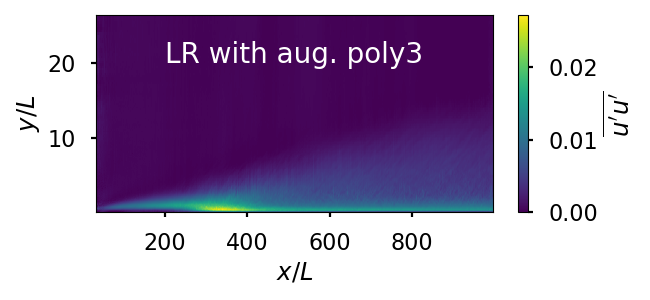

In [783]:
#uu_pred = predicted[:,0].reshape(u[:,10:-10].shape)
#uu_pred = LR_predicted[:,0].reshape(u.shape)
uu_pred = linear_predict.reshape(u[:,10:-10].shape)
#nmask = uu_pred<0
#uu_pred[nmask]=0

#fig1,ax1=plt.subplots(figsize=(2.9,2))
fig1,ax1=plt.subplots(figsize=(6.5,3))
vmin=np.min([uu[:,10:-10]-u[:,10:-10]*u[:,10:-10],uu_pred])
vmax=np.max([uu[:,10:-10]-u[:,10:-10]*u[:,10:-10],uu_pred])
vm=np.max([np.abs(vmax),np.abs(vmin)])

fig1.colorbar(ax1.pcolormesh(x,y,uu-u*u,vmin=0,vmax=vmax,cmap=plt.cm.viridis),ax=ax1,label=r"$\overline{u'u'}$")
#fig1.colorbar(ax1.contourf(X,Y,uu-u*u,64,vmin=-vm,vmax=vm,cmap=plt.cm.seismic),ax=ax1,label=r"$\overline{u'u'}$")
ax1.set_xlabel(r'$x/L$')
ax1.set_ylabel(r'$y/L$')
fig1.tight_layout()
#fig1.savefig('upup_linear_poly3_4aug_JHTD_poster.png',dpi=600)
#fig1.savefig('upup_LR_poly3_4aug_JHTD_poster.png',dpi=600)
fig1.savefig('upup_JHTDB_poster.png',dpi=600)

#fig2,ax2=plt.subplots(figsize=(2.9,2))
fig2,ax2=plt.subplots(figsize=(6.5,3))
fig2.colorbar(ax2.pcolormesh(x[10:-10],y,uu_pred,vmin=0,vmax=vmax,cmap=plt.cm.viridis),ax=ax2,label=r"$\overline{u'u'}$")
#fig2.colorbar(ax2.contourf(X,Y,uu_pred.reshape(uu.shape),128,vmin=-vm,vmax=vm,cmap=plt.cm.seismic),ax=ax2,label=r"$\overline{u'u'}$")
ax2.set_xlabel(r'$x/L$')
ax2.set_ylabel(r'$y/L$')
ax2.text(200, 20, r'LR with aug. poly3', color='w',fontsize=20)
fig2.tight_layout()
fig2.savefig('upup_LR_poly3_4aug_JHTDB_predicted_poster.png',dpi=600)

In [761]:
r2_score(uu_pred,uu[:,10:-10]-u[:,10:-10]*u[:,10:-10])

0.9857472864865326

In [375]:
np.argmin(uu_pred.reshape(uu.shape))
#X[0,0],Y[0,0],uu_pred[0]

26560

In [73]:
LR_Model=model
LR_predicted = predicted

<IPython.core.display.Javascript object>


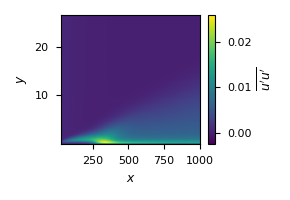

<IPython.core.display.Javascript object>


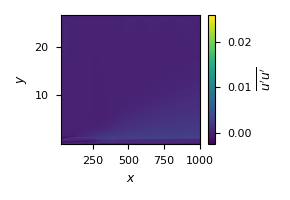

In [93]:
uu_pred = predicted[:,0].reshape(u.shape)

fig1,ax1=plt.subplots(figsize=(2.9,2))
vmin=np.min([uu-u*u,uu_pred])
vmax=np.max([uu-u*u,uu_pred])

fig1.colorbar(ax1.pcolormesh(x,y,uu-u*u,vmin=vmin,vmax=vmax),ax=ax1,label=r"$\overline{u'u'}$")
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
fig1.tight_layout()
fig1.savefig('upup_NN1_JHTDB.png',dpi=600)

fig2,ax2=plt.subplots(figsize=(2.9,2))
fig2.colorbar(ax2.pcolormesh(x,y,uu_pred,vmin=vmin,vmax=vmax),ax=ax2,label=r"$\overline{u'u'}$")
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')
fig2.tight_layout()
fig2.savefig('upup_NN1_JHTDB_predicted.png',dpi=600)

In [40]:
X.shape

(224, 3320)

In [41]:
224*3320

743680

In [402]:
linear_predict

array([-6483005.38945361, -6373449.64585522, -6265477.54401501, ...,
         239598.91802357,   239188.09503103,   238468.01509552])

<IPython.core.display.Javascript object>


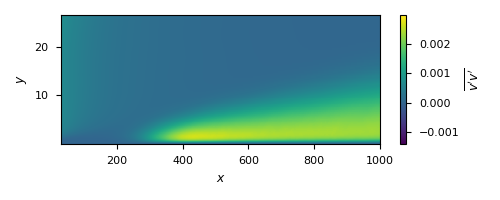

<IPython.core.display.Javascript object>


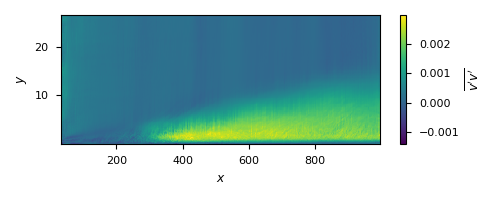

In [428]:
#vv_pred = predicted[:,0].reshape(u.shape)
vv_pred = linear_predict

fig1,ax1=plt.subplots(figsize=(5,2))
vmin=np.min([vv[:,10:-10]-v[:,10:-10]*v[:,10:-10],vv_pred.reshape(v[:,10:-10].shape)])
vmax=np.max([vv[:,10:-10]-v[:,10:-10]*v[:,10:-10],vv_pred.reshape(v[:,10:-10].shape)])

fig1.colorbar(ax1.pcolormesh(x,y,vv-v*v,vmin=vmin,vmax=vmax),ax=ax1,label=r"$\overline{v'v'}$")
#fig1.colorbar(ax1.pcolormesh(x,y,vv-v*v),ax=ax1,label=r"$\overline{v'v'}$")
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
fig1.tight_layout()
fig1.savefig('vpvp_JHTDB.png',dpi=600)

fig2,ax2=plt.subplots(figsize=(5,2))
fig2.colorbar(ax2.pcolormesh(x[10:-10],y,vv_pred.reshape(v[:,10:-10].shape),vmin=vmin,vmax=vmax),ax=ax2,label=r"$\overline{v'v'}$")
#fig2.colorbar(ax2.pcolormesh(x,y,vv_pred.reshape(v.shape)),ax=ax2,label=r"$\overline{v'v'}$")
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')
fig2.tight_layout()
fig2.savefig('vpvp_JHTDB_predicted.png',dpi=600)

In [425]:
v.shape

(224, 3320)

<IPython.core.display.Javascript object>


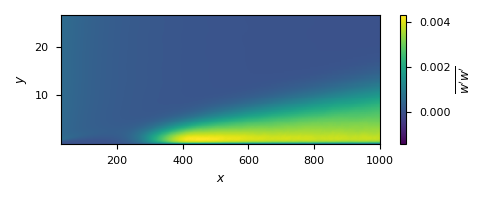

<IPython.core.display.Javascript object>


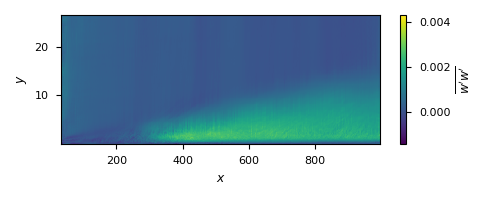

In [432]:
#ww_pred = predicted[:,2].reshape(u.shape)
ww_pred = linear_predict.reshape(u[:,10:-10].shape)

fig1,ax1=plt.subplots(figsize=(5,2))
vmin=np.min([ww[:,10:-10]-w[:,10:-10]*w[:,10:-10],ww_pred])
vmax=np.max([ww[:,10:-10]-w[:,10:-10]*w[:,10:-10],ww_pred])

fig1.colorbar(ax1.pcolormesh(x,y,ww-w*w,vmin=vmin,vmax=vmax),ax=ax1,label=r"$\overline{w'w'}$")
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
fig1.tight_layout()
fig1.savefig('wpwp_JHTDB.png',dpi=600)

fig2,ax2=plt.subplots(figsize=(5,2))
fig2.colorbar(ax2.pcolormesh(x[10:-10],y,ww_pred,vmin=vmin,vmax=vmax),ax=ax2,label=r"$\overline{w'w'}$")
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')
fig2.tight_layout()
fig2.savefig('wpwp_JHTDB_predicted.png',dpi=600)

<IPython.core.display.Javascript object>


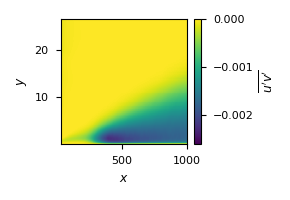

<IPython.core.display.Javascript object>


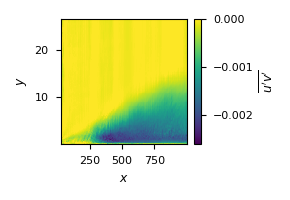

In [480]:
uv_pred = linear_predict.reshape(uv[:,10:-10].shape)

fig1,ax1=plt.subplots(figsize=(2.9,2))
vmin=np.min([uv[:,10:-10]-u[:,10:-10]*v[:,10:-10],uv_pred])
vmax=np.max([uv[:,10:-10]-u[:,10:-10]*v[:,10:-10],uv_pred])
vm=np.max([np.abs(vmax),np.abs(vmin)])

#fig1.colorbar(ax1.pcolormesh(x,y,uv-u*v,vmin=0,vmax=vmax,cmap=plt.cm.viridis),ax=ax1,label=r"$\overline{u'v'}$")
fig1.colorbar(ax1.pcolormesh(x,y,uv-u*v,vmin=vmin,vmax=0,cmap=plt.cm.viridis),ax=ax1,label=r"$\overline{u'v'}$")
#fig1.colorbar(ax1.contourf(X,Y,uu-u*u,64,vmin=-vm,vmax=vm,cmap=plt.cm.seismic),ax=ax1,label=r"$\overline{u'u'}$")
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
fig1.tight_layout()
fig1.savefig('upvp_linear_JHTDB.png',dpi=600)

fig2,ax2=plt.subplots(figsize=(2.9,2))
fig2.colorbar(ax2.pcolormesh(x[10:-10],y,uv_pred,vmin=vmin,vmax=0,cmap=plt.cm.viridis),ax=ax2,label=r"$\overline{u'v'}$")
#fig2.colorbar(ax2.contourf(X,Y,uu_pred.reshape(uu.shape),128,vmin=-vm,vmax=vm,cmap=plt.cm.seismic),ax=ax2,label=r"$\overline{u'u'}$")
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')
fig2.tight_layout()
fig2.savefig('upvp_linear_JHTDB_predicted.png',dpi=600)

<IPython.core.display.Javascript object>


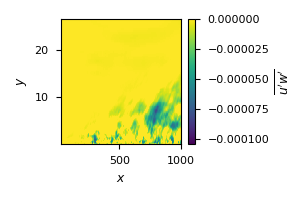

<IPython.core.display.Javascript object>


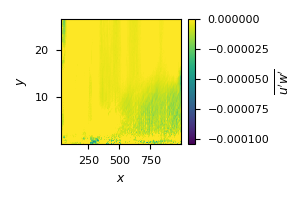

In [453]:
uw_pred = linear_predict.reshape(uw[:,10:-10].shape)

fig1,ax1=plt.subplots(figsize=(2.9,2))
vmin=np.min([uw[:,10:-10]-u[:,10:-10]*w[:,10:-10],uw_pred])
vmax=np.max([uw[:,10:-10]-u[:,10:-10]*w[:,10:-10],uw_pred])
vm=np.max([np.abs(vmax),np.abs(vmin)])

#fig1.colorbar(ax1.pcolormesh(x,y,uw-u*w,vmin=0,vmax=vmax,cmap=plt.cm.viridis),ax=ax1,label=r"$\overline{u'w'}$")
fig1.colorbar(ax1.pcolormesh(x,y,uw-u*w,vmin=vmin,vmax=0,cmap=plt.cm.viridis),ax=ax1,label=r"$\overline{u'w'}$")
#fig1.colorbar(ax1.contourf(X,Y,uu-u*u,64,vmin=-vm,vmax=vm,cmap=plt.cm.seismic),ax=ax1,label=r"$\overline{u'u'}$")
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
fig1.tight_layout()
fig1.savefig('upwp_linear_JHTDB.png',dpi=600)

fig2,ax2=plt.subplots(figsize=(2.9,2))
fig2.colorbar(ax2.pcolormesh(x[10:-10],y,uw_pred,vmin=vmin,vmax=0,cmap=plt.cm.viridis),ax=ax2,label=r"$\overline{u'w'}$")
#fig2.colorbar(ax2.contourf(X,Y,uu_pred.reshape(uu.shape),128,vmin=-vm,vmax=vm,cmap=plt.cm.seismic),ax=ax2,label=r"$\overline{u'u'}$")
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')
fig2.tight_layout()
fig2.savefig('upwp_linear_JHTDB_predicted.png',dpi=600)

<IPython.core.display.Javascript object>


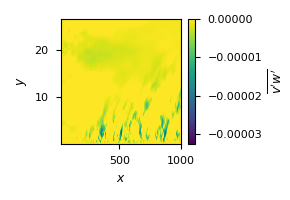

/home/srharris/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<IPython.core.display.Javascript object>


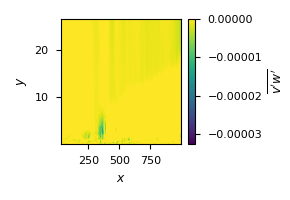

In [494]:
vw_pred = linear_predict.reshape(vw[:,10:-10].shape)

fig1,ax1=plt.subplots(figsize=(2.9,2))
vmin=np.min([vw[:,10:-10]-v[:,10:-10]*w[:,10:-10],vw_pred])
vmax=np.max([vw[:,10:-10]-v[:,10:-10]*w[:,10:-10],vw_pred])
vm=np.max([np.abs(vmax),np.abs(vmin)])

#fig1.colorbar(ax1.pcolormesh(x,y,vw-v*w,vmin=0,vmax=vmax,cmap=plt.cm.viridis),ax=ax1,label=r"$\overline{v'w'}$")
fig1.colorbar(ax1.pcolormesh(x,y,vw-v*w,vmin=vmin,vmax=0,cmap=plt.cm.viridis),ax=ax1,label=r"$\overline{v'w'}$")
#fig1.colorbar(ax1.contourf(X,Y,uu-u*u,64,vmin=-vm,vmax=vm,cmap=plt.cm.seismic),ax=ax1,label=r"$\overline{u'u'}$")
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
fig1.tight_layout()
fig1.savefig('vpwp_linear_JHTDB.png',dpi=600)

fig2,ax2=plt.subplots(figsize=(2.9,2))
fig2.colorbar(ax2.pcolormesh(x[10:-10],y,vw_pred,vmin=vmin,vmax=0,cmap=plt.cm.viridis),ax=ax2,label=r"$\overline{v'w'}$")
#fig2.colorbar(ax2.contourf(X,Y,uu_pred.reshape(uu.shape),128,vmin=-vm,vmax=vm,cmap=plt.cm.seismic),ax=ax2,label=r"$\overline{u'u'}$")
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')
fig2.tight_layout()
fig2.savefig('vpwp_linear_JHTDB_predicted.png',dpi=600)

In [351]:
Base.close()